In [1]:
cd ..

/home/sam/cc-net


/home/sam/anaconda3/envs/primal-dual/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import torch
import scipy.sparse as sp
from scipy.sparse import coo_matrix, triu

import yaml
import models.models as Models
import losses.losses as Losses
import datasets.datasets as Datasets

from tqdm.notebook import tqdm

In [3]:
def plot_graph(X, edge_index, ax):
    for i, j in zip(edge_index[0], edge_index[1]):
        ax.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color='0.8', alpha=0.8, zorder=1) 
    ax.scatter(X[:, 0], X[:, 1], edgecolors='none', color='red', zorder=2)

In [4]:
def visualize_clusters(X, U, ax, point_size=8, label="Clustered data"):
    """Plot the loss curve and a grayscale scatter of the smoothed solution U."""
    fig = plt.figure(figsize=(10,4))
    ax.scatter(X[:, 0], X[:, 1], s=8, edgecolors='none', alpha=0.5, label='original data')
    ax.scatter(U[:,0].cpu(), U[:,1].cpu(), s=point_size, alpha=0.9, c='0.4', label=label)

In [5]:
def load_model(model_cfg, model_pth):
    model_class = getattr(Models, model_config['model'])
    model = model_class(**model_config['cfg'])
    model = model.float()
    model_state = torch.load(model_pth, map_location='cpu')
    model.load_state_dict(model_state)
    return model

def forward_pass(model, data):
    src = data.edge_index[0]
    dst = data.edge_index[1]
    e_init = data.x[src] - data.x[dst]
    h, e = model(h=data.x.float(),
                 e=e_init.float(), 
                 edge_index = data.edge_index, 
                 w=data.edge_attr,
                 x=data.x.float())
    return h.detach(), e.detach()
    
def get_primal_obj(U, data, lam):
    src = data.edge_index[0]
    dst = data.edge_index[1]
    w = data.edge_attr
    X = data.x
    return Losses.energy(U, X, src, dst, w, lam)

In [6]:
exp_file = 'configs/single-runs/pdhg-knn.yaml'
with open(exp_file, "r") as f:
    exp_cfg = yaml.safe_load(f)

In [28]:
model_config = exp_cfg['model_config']
lam_1_pth = '/data/sam/primal-dual/energy_pdg/multiple_knn/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L5_H128_inN32_inE32_lam1.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/0b2mc0ic/final.pt'
lam_2_pth = '/data/sam/primal-dual/energy_pdg/multiple_knn/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L5_H128_inN32_inE32_lam2.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/4lxz7zi9/final.pt'
lam_3_pth = '/data/sam/primal-dual/energy_pdg/multiple_knn/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L5_H128_inN32_inE32_lam3.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/5xg128iv/final.pt'
lam_10_pth = '/data/sam/primal-dual/energy_pdg/multiple_knn/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L5_H128_inN32_inE32_lam10.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/714x7g4h/final.pt'
lam_10_pth_9L = '/data/sam/primal-dual/energy_pdg/multiple_knn/EncodeProcessDecode/GraphPDHGNet/PDHGLayer_L9_H128_inN32_inE32_lam10.0_tau0.35_sig0.35_resid=False_steps=1_featDim=2/pmucsj6u/final.pt'
lam_1_model = load_model(model_config, lam_1_pth)
lam_2_model = load_model(model_config, lam_2_pth)
lam_3_model = load_model(model_config, lam_3_pth)
lam_10_model = load_model(model_config, lam_10_pth)
model_config['cfg']['processor_cfg']['cfg']['num_layers'] = 9
lam_10_model_9L = load_model(model_config, lam_10_pth_9L)

In [22]:
datapth = '/data/sam/primal-dual/data/multiple_knn_base=two_moons_n_samples=200_n_graphs=100_noise=0.15-train.pt'
dataset = torch.load(datapth)

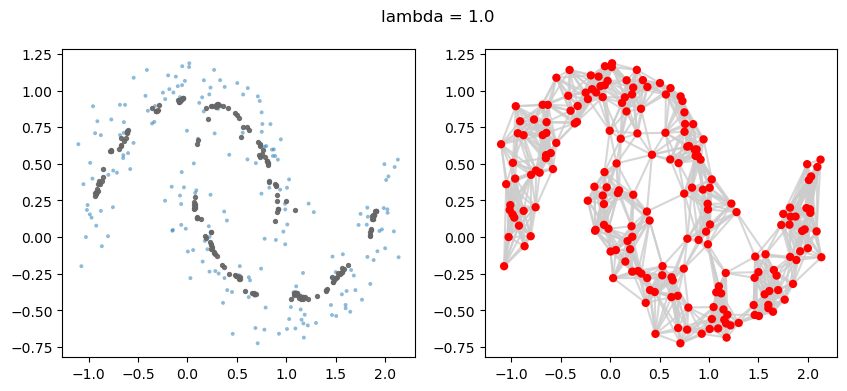

<Figure size 1000x400 with 0 Axes>

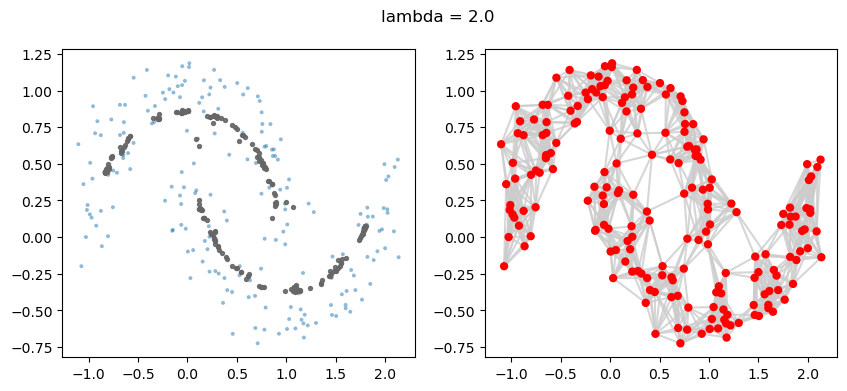

<Figure size 1000x400 with 0 Axes>

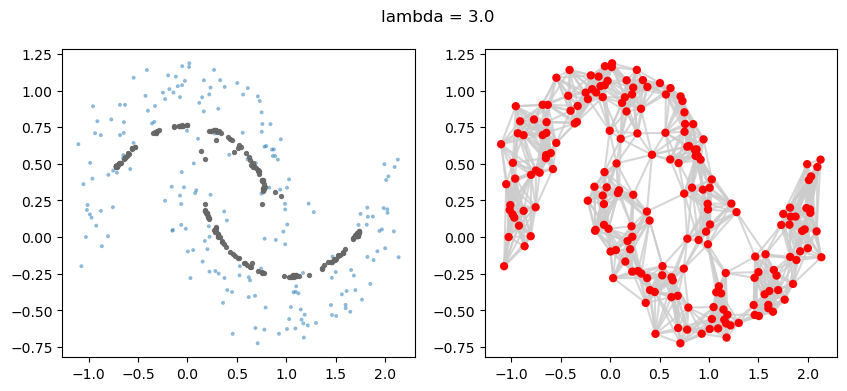

<Figure size 1000x400 with 0 Axes>

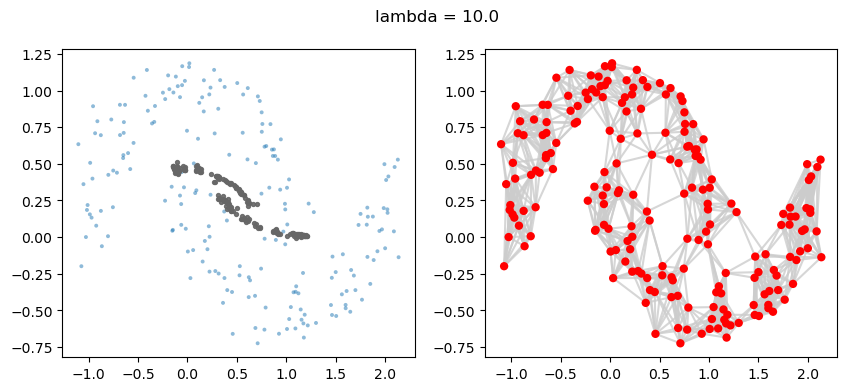

<Figure size 1000x400 with 0 Axes>

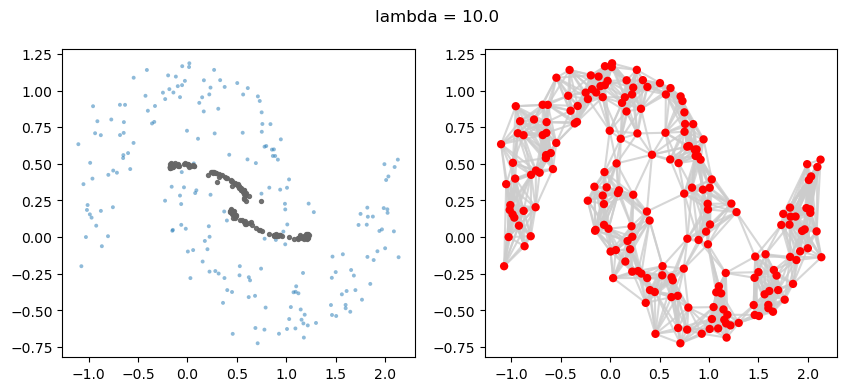

<Figure size 1000x400 with 0 Axes>

In [29]:
models = [lam_1_model, lam_2_model, lam_3_model, lam_10_model, lam_10_model_9L]
lambdas = [1.0, 2.0, 3.0, 10.0, 10.0]
example_graph = dataset[0]
for i in range(5):
    model = models[i]
    h, e = forward_pass(model, example_graph)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    visualize_clusters(example_graph.x, h, axs[0])
    plot_graph(example_graph.x,example_graph.edge_index, axs[1])
    fig.suptitle(f"lambda = {lambdas[i]}")

In [14]:
baseline_output = torch.load('/data/sam/primal-dual/data/multiple_knn_base=two_moons_n_samples=200_n_graphs=100_noise=0.15-train.pt_lam=1.0/output-eUjYSjPX5YMFuGQ8VLKGBn.pt')


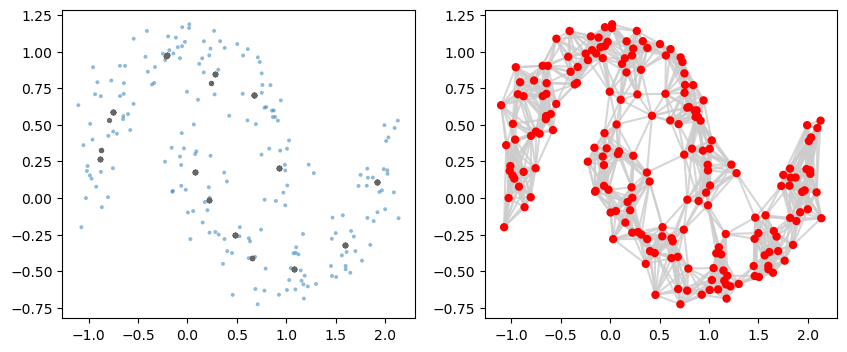

<Figure size 1000x400 with 0 Axes>

In [20]:
baseline_U = baseline_output['U'][0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
visualize_clusters(example_graph.x, baseline_U, axs[0])
plot_graph(example_graph.x,example_graph.edge_index, axs[1])